# Cutaneous Vs. Mucosal analysis

##### 1. Melanoma association with clusters analysis - 
Each cluster see the number of cells correspond to cutaneous patients vs. number of cells corespond to mucosal patients.

##### 2. GEP association with melanoma -
Per program, take all usage values of cells coming from cutaneous patients vs. mucosal patients, and perform Wilcoxon ranksum test.

##### 3. GEP association with melanoma (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between cutaneous and mucosal patients.


In [18]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic, transpose, bold
from general_helpers import create_folder
from scipy.stats import ranksums, wilcoxon
from shutil import copyfile
import matplotlib.pyplot as plt
import random
from utilities.clustering_tools import find_marker_genes_in_cluster, find_markers_in_clusters
from utilities.clustering_tools import multipletests_fdr

Helper functions:

In [2]:
def print_pvals(pvals, n_groups):
    
    pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, n_groups+1)])], columns=['pval', 'group'])
    plt.figure(figsize=(8, 6), dpi=80);

    pvals = pvals_df[["group", "pval"]].values
    small_pvals = pvals[pvals[:,1]<0.05]
    big_pvals = pvals[pvals[:,1]>=0.05]


    plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1]);
    plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1]);

    ax = plt.plot([0,n_groups+1],[0.05,0.05], color='y');
    plt.xticks(np.arange(1, n_groups+1));
    plt.yticks([0.05, 1]);
    plt.xlim((0,n_groups+1));
    plt.title('p-values');

    for coord in pvals:
        plt.text(coord[0], coord[1], '{}'.format(int(coord[0])));

##### Loads clinical table to get labels - Mucosal/Cutaneous

In [3]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

# Melanoma type
# res_melanoma_clinical_data = res_melanoma_clinical_data[(res_melanoma_clinical_data['Melanoma type']=='Cutaneous') | (res_melanoma_clinical_data['Melanoma type']=='Mucosal ')]
melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal ', 'Uveal': 'other', 'UN primary': 'other', 'Acral': 'other', 'Unknown': 'other'}
res_melanoma_clinical_data['Melanoma type'] = res_melanoma_clinical_data['Melanoma type'].apply(lambda rr: melanoma_type_translate[rr])
# res_melanoma_clinical_data

In [4]:
res_melanoma_clinical_data.head(5)

,Clinical response,Melanoma type,response
Patient id,,,
M97,R,Cutaneous,R
M98,R (had a response in 2016-2019),Cutaneous,R
M99,NR (PD),Mucosal,NR
M100,NR (SD),Cutaneous,NR
M101,NED- 10/5/20,other,R


In [5]:
res_melanoma_clinical_data['Melanoma type'].value_counts()

Cutaneous    31
Mucosal       8
other         7
Name: Melanoma type, dtype: int64

#### Builds Mucosal/Cutaneous sample list

In [6]:
cutaneous_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'Cutaneous'].index.tolist()
mucosal_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'Mucosal '].index.tolist()
no_used_samples = res_melanoma_clinical_data[res_melanoma_clinical_data['Melanoma type'] == 'other'].index.tolist()

print(f'number cutaneous_samples: {len(cutaneous_samples)}')
print(f'number mucosal_samples: {len(mucosal_samples)}')
print(f'number of \'other\' samples: {len(no_used_samples)}')


number cutaneous_samples: 31
number mucosal_samples: 8
number of 'other' samples: 7


# 1. Melanoma association with clusters analysis

Each cluster see the number of cells correspond to cutaneous patients vs. number of cells corespond to mucosal patients.


In [7]:
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

###### cluster visualizations

In [8]:
df = clusters_barcodes_mapping_df.drop(columns=['index', 'Unnamed: 0'])
df['Melanoma type'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

n_cutaneous = df['Melanoma type'].value_counts()['Cutaneous']
n_mucosal = df['Melanoma type'].value_counts()['Mucosal ']

In [9]:
clusters = df['Cluster'].unique()

cutaneous_counts = np.zeros(len(clusters))
mucosal_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    melanoma_type = df[df['Cluster']==cluster]['Melanoma type']
    cutaneous_counts[idx] = sum(melanoma_type=='Cutaneous')
    mucosal_counts[idx] = sum(melanoma_type=='Mucosal ')


RanksumsResult(statistic=3.8105117766515297, pvalue=0.0001386794054294884)
WilcoxonResult(statistic=0.0, pvalue=0.00048828125)


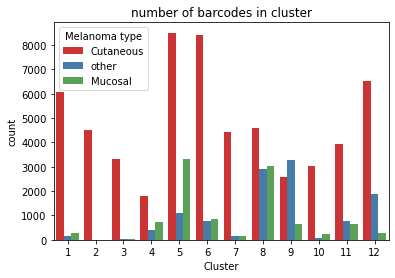

In [10]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Melanoma type', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(cutaneous_counts, mucosal_counts))
print(wilcoxon(cutaneous_counts, mucosal_counts))

##### Normalized by group size (number of barcodes in group - Mucosal/Cutaneous):

In [11]:
df = df[df['Melanoma type']!='other']

Normalized by number of barcodes in group (Mucosal/Cutaneous):

RanksumsResult(statistic=1.5588457268119895, pvalue=0.11903289845700783)
WilcoxonResult(statistic=29.0, pvalue=0.4697265625)


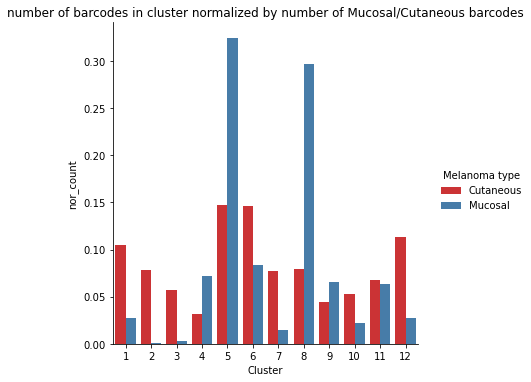

In [12]:
cutaneous_nor = cutaneous_counts/n_cutaneous
mucosal_nor = mucosal_counts/n_mucosal

print('Normalized by number of barcodes in group (Mucosal/Cutaneous):')

count_df = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_cutaneous if x['Melanoma type']=='Cutaneous' else x['count']/n_mucosal ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of Mucosal/Cutaneous barcodes')
    
print()
print(ranksums(cutaneous_nor, mucosal_nor))
print(wilcoxon(cutaneous_nor, mucosal_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=4.156921938165305, pvalue=3.225641456243767e-05)
WilcoxonResult(statistic=0.0, pvalue=0.00048828125)


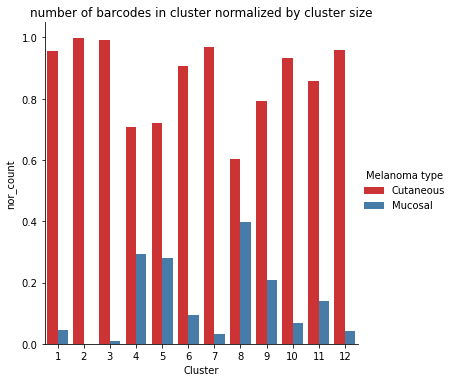

In [13]:
cutaneous_nor = cutaneous_counts/(cutaneous_counts + mucosal_counts) #n_cutaneous
mucosal_nor = mucosal_counts/(cutaneous_counts + mucosal_counts) #n_mucosal


    
df_nor_count = df.groupby(['Melanoma type', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Melanoma type', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(cutaneous_nor, mucosal_nor))
print(wilcoxon(cutaneous_nor, mucosal_nor))

##### patient fraction over clusters

In [14]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['index', 'Cluster'])

sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Melanoma type'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

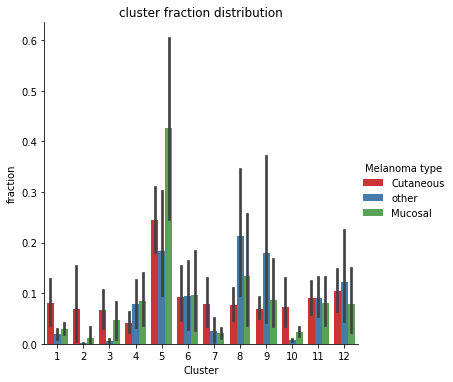

In [15]:
sns.reset_orig()
ax = sns.catplot(kind="bar", x='Cluster', y='fraction', hue='Melanoma type', data=sample_fractions_df, palette="Set1").set(title="cluster fraction distribution")

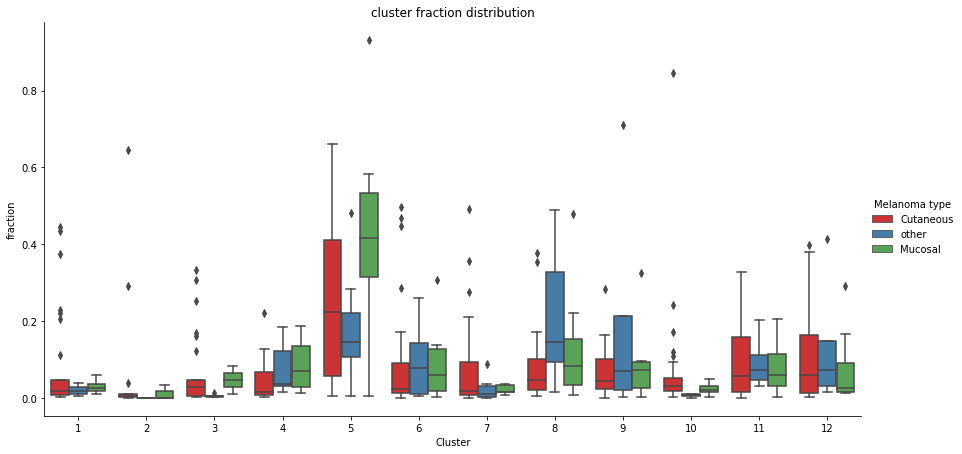

In [16]:
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Melanoma type', data=sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")

### zero fraction samples are not included

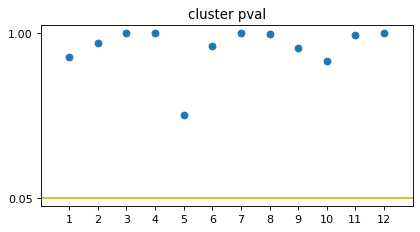

In [17]:
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = sample_fractions_df[sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df['Melanoma type'] == 'Cutaneous']['fraction'].values
    NR_fractions = cluster_df[cluster_df['Melanoma type'] == 'Mucosal ']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals

pvals = np.array(pvals)
# Correct pvals
pvals[:,1] = multipletests_fdr(pvals[:,1])[1]
plt.scatter(x=pvals[:,0], y=pvals[:,1],)
ax = plt.plot([0,13],[0.05,0.05], color='y');
plt.xticks(np.arange(1, 13));
plt.yticks([0.05, 1]);
plt.xlim((0,13));
plt.title('cluster pval');

See how many samples (R/NR) have cells in each cluster:

In [19]:
# sample_fractions_df[["Sample", 'Cluster']].groupby('Cluster').count()
# sample_fractions_df[["Sample", 'Cluster', 'Response']].groupby(['Cluster','Response']).count()

### zero fraction samples are included:

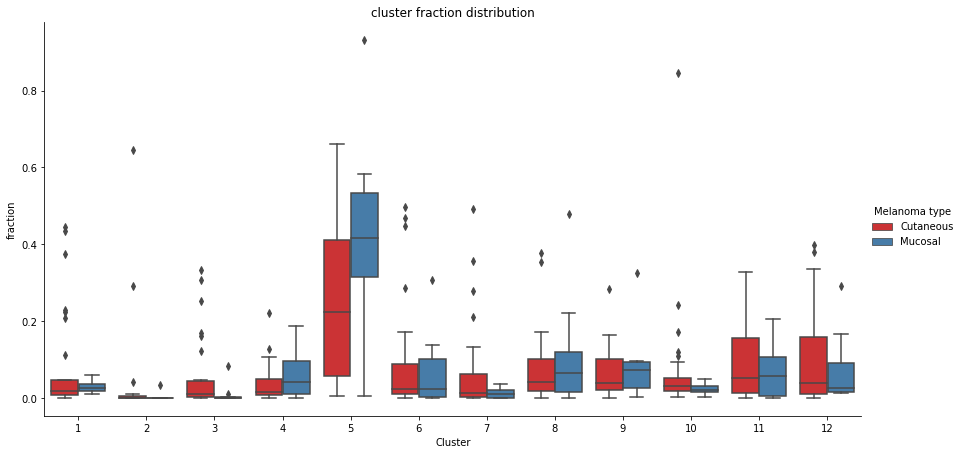

<Figure size 480x240 with 0 Axes>

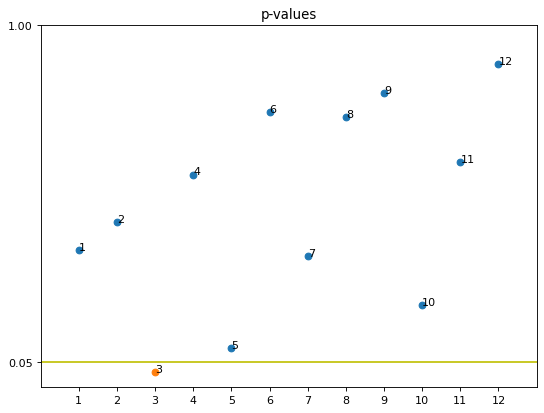

In [20]:
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Melanoma type']!='other'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = cutaneous_samples + mucosal_samples
dic_response = {ss:'Cutaneous' for ss in cutaneous_samples}
dic_response.update({ss:'Mucosal ' for ss in mucosal_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Melanoma type', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    cutaneous_fractions = cluster_df[cluster_df['Melanoma type'] == 'Cutaneous']['fraction'].values
    mucosal_fractions = cluster_df[cluster_df['Melanoma type'] == 'Mucosal ']['fraction'].values
    res = ranksums(cutaneous_fractions, mucosal_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
# pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], 12)
# pvals

# cutaneous_samples
# mucosal_samples

# GEP

In [21]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_26.6.21'
selected_K = 32
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '32'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [22]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df['Melanoma type'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])


Shows which programs are activity programs, displays the number of samples associated with each program.

In [23]:
activity_programs_df = df.copy()


cell_usage_threshold = 0.2
sample_portion_threshold = 0.2
activity_programs_df.iloc[:,:32] = activity_programs_df.iloc[:,:32] > cell_usage_threshold

sample_counts_df = activity_programs_df.groupby('sample').sum().reset_index().set_index('sample')
samples_num_barcodes = pd.DataFrame(activity_programs_df.groupby('sample')['barcode'].count()).rename(columns={'barcode':'count'})  #.agg({'barcode': ['count']}).reset_index()
sample_fraction_df = sample_counts_df.div(samples_num_barcodes.loc[sample_counts_df.index]['count'], axis=0)

# sample_fraction_df
num_of_program_in_sample = sample_fraction_df > sample_portion_threshold

activity_programs_idx = np.array(num_of_program_in_sample.columns)[num_of_program_in_sample.sum()>1].astype(int)

print(f'Number of activity programs (more than 2 samples are associated): {len(activity_programs_idx)}')
print(f'Activity programs (more than 2 samples are associated): {activity_programs_idx}')

# num_of_program_in_sample.sum()

Number of activity programs (more than 2 samples are associated): 14
Activity programs (more than 2 samples are associated): [ 1  2 10 12 13 14 16 17 21 23 24 29 31 32]


# 2. GEP association with response (1)

Per program, take all usage values of cells coming from cutaneous patients vs. mucosal patients, and perform Wilcoxon ranksum test.

In [24]:
df_cutaneous = df[df['Melanoma type']=='Cutaneous']
df_mucosal = df[df['Melanoma type']=='Mucosal ']

pvals = np.zeros(selected_K)
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(df_mucosal[i].values, df_cutaneous[i].values)[1]

# Correct pvals
pvals = multipletests_fdr(pvals)[1].tolist()

pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, selected_K+1)])], columns=['pval', 'program'])

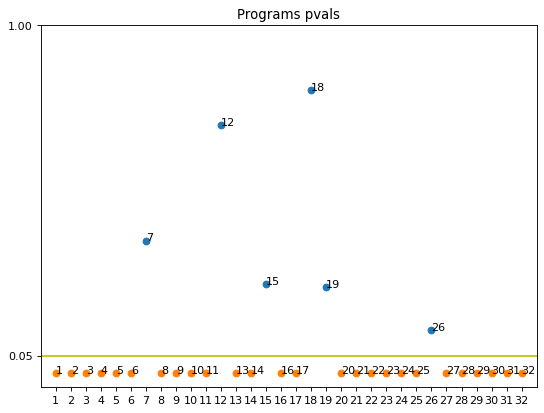

In [25]:
plt.figure(figsize=(8, 6), dpi=80)

pvals = pvals_df[["program", "pval"]].values
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05, 1]);
plt.xlim((0,33));
plt.title('Programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

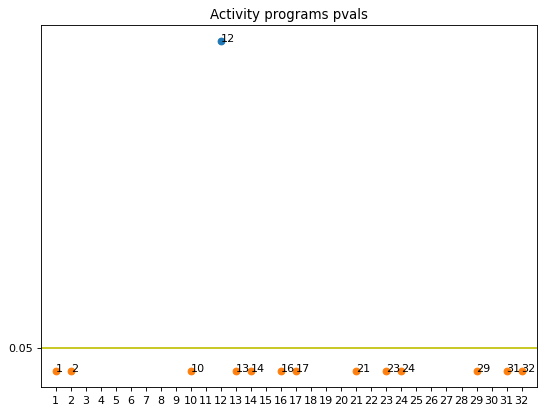

In [26]:
plt.figure(figsize=(8, 6), dpi=80)

int_prog_indxes = activity_programs_idx-1
pvals = pvals_df[["program", "pval"]].values[int_prog_indxes]
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05]);
plt.xlim((0,33));
plt.title('Activity programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

#### Present Usage distribution of activity programs in different forms:

Usage distribution of activity programs


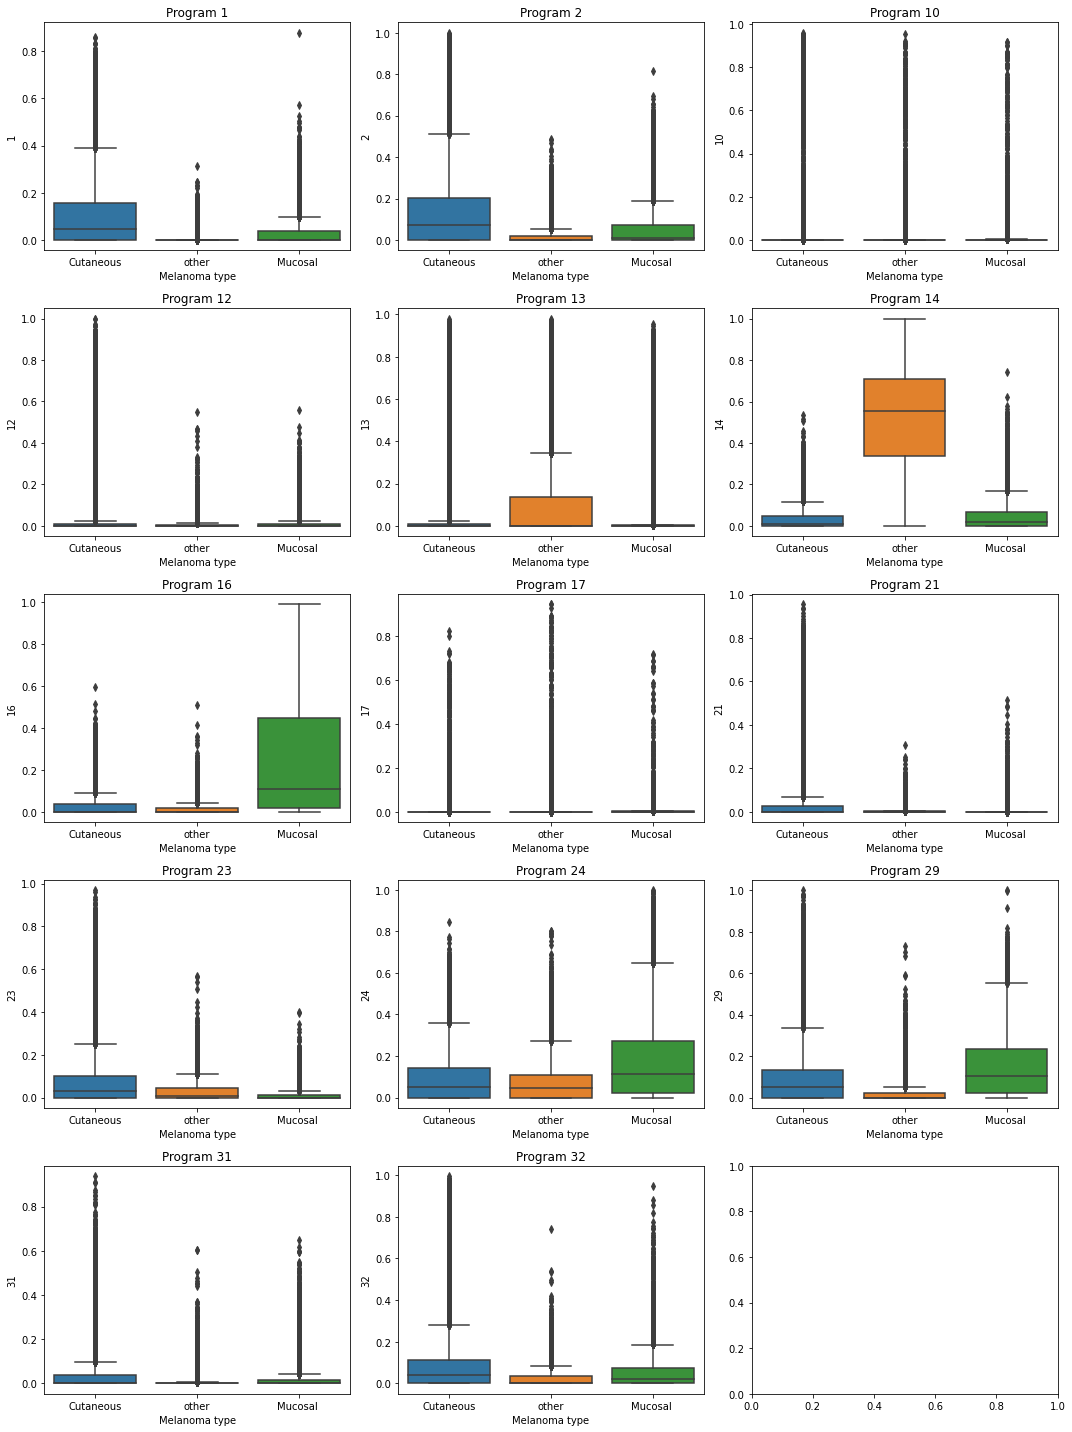

In [27]:
# sns.reset_orig()
import itertools
index = [(x,y) for x in np.arange(11) for y in np.arange(3)]

fig, axs = plt.subplots(int(np.ceil(len(activity_programs_idx)/3)), 3)
fig.set_size_inches(15, 20)
# for i in range(32):
print('Usage distribution of activity programs')
for i, p_idx in enumerate(int_prog_indxes):
    axs[index[i][0], index[i][1]].set_title(f"Program {p_idx+1}")
    sns.boxplot(ax=axs[index[i][0], index[i][1]], y=p_idx+1, x='Melanoma type', data=df).set(title=f'Program {p_idx+1}');
plt.tight_layout()


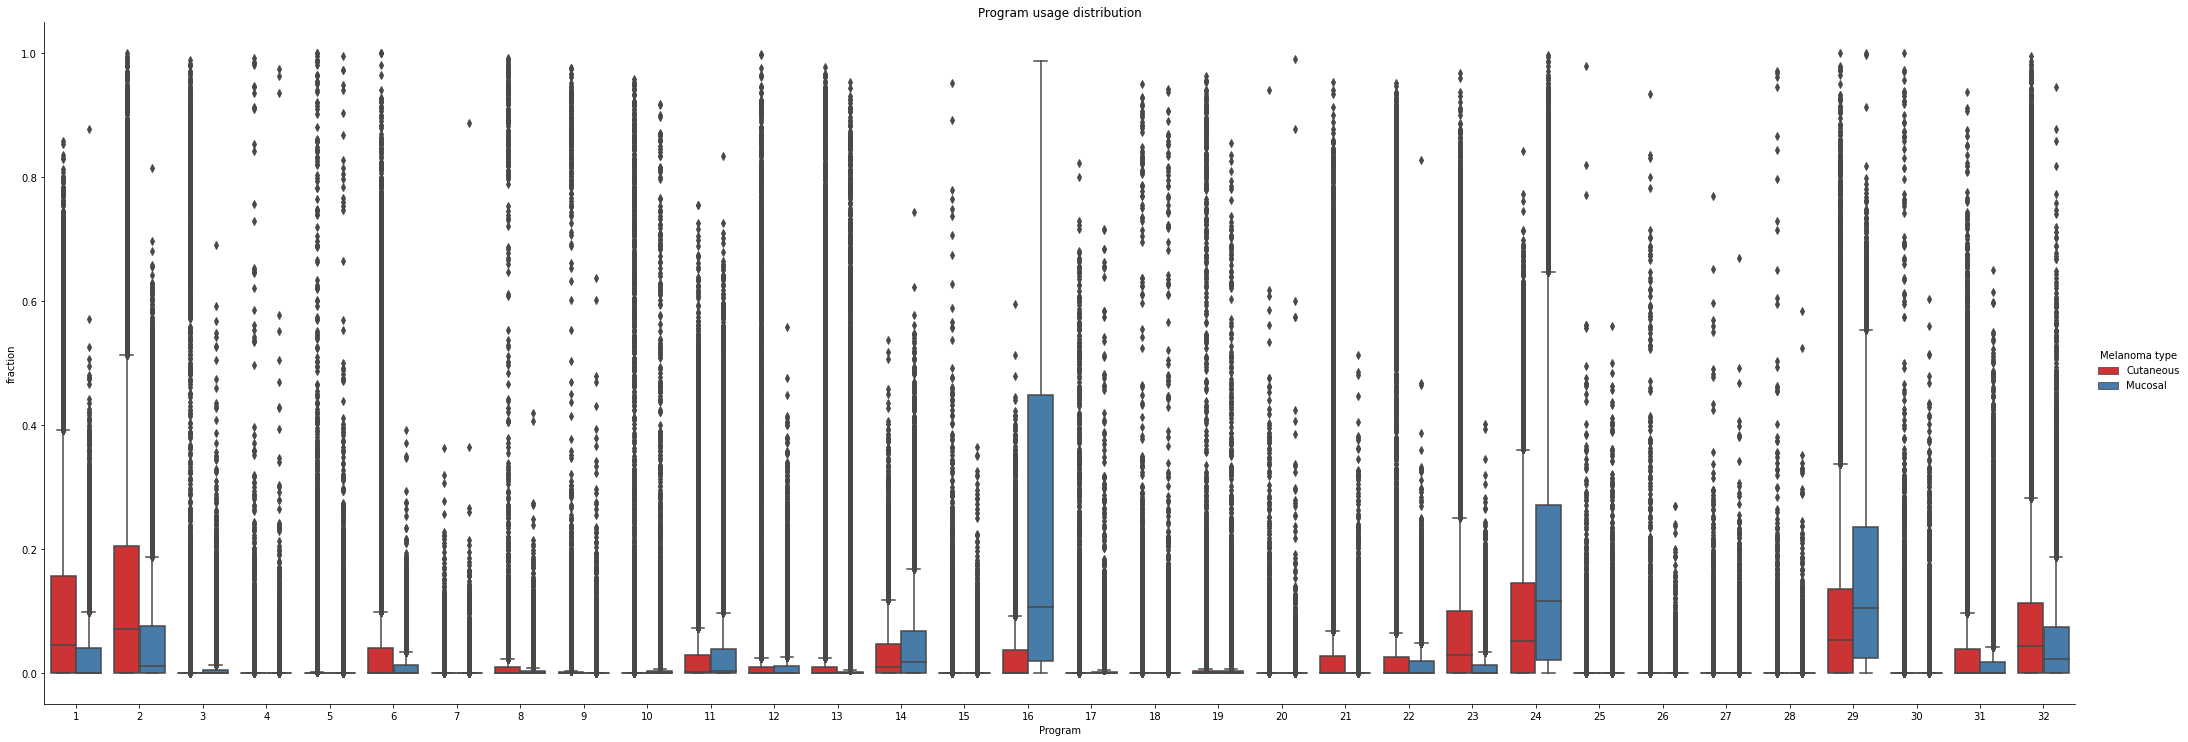

In [28]:
frac_df = df.melt(id_vars=['sample', 'barcode', 'Melanoma type'],
        value_vars=list(range(1,33)), var_name ='Program', value_name ='fraction')
frac_df = frac_df[frac_df['Melanoma type']!='other']

sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Melanoma type', data=frac_df, palette="Set1",height=10, aspect=2.9).set(title="Program usage distribution")


### only activity programs:

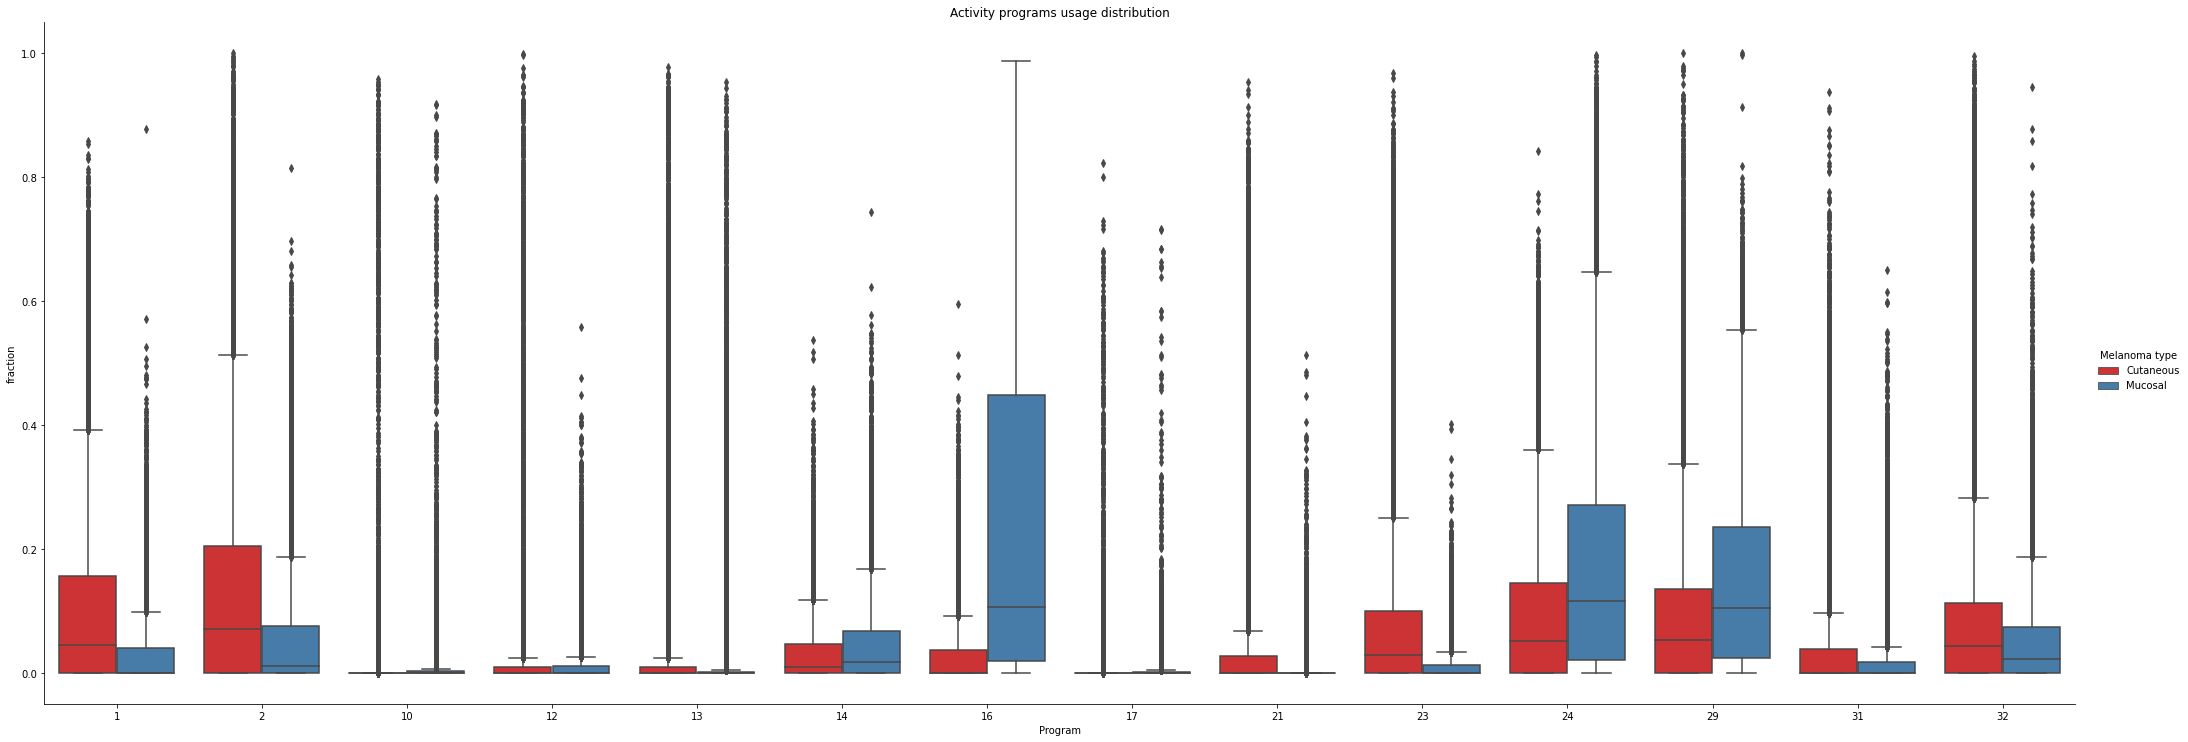

In [63]:
frac_df = frac_df[frac_df['Program'].isin(activity_programs_idx)]
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Melanoma type', data=frac_df, palette="Set1",height=10, aspect=2.9).set(title="Activity programs usage distribution")


# 3. GEP association with response (2)

Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between cutaneous and mucosal patients.


###### Loads usages:

In [29]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_26.6.21'
selected_K = 32
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '32'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [30]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df['Melanoma type'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['Melanoma type'])

df_cutaneous = df[df['Melanoma type']=='Cutaneous']
df_mucosal = df[df['Melanoma type']=='Mucosal ']

##### Assign each cell one program based on the maximal usage value.

In [31]:
cutaneous_high_prog = np.argmax(df_cutaneous[list(range(1,33))].values, axis=1)+1
mucosal_high_prog = np.argmax(df_mucosal[list(range(1,33))].values, axis=1)+1

df_cutaneous['associated program'] = cutaneous_high_prog
df_mucosal['associated program'] = mucosal_high_prog

<ipython-input-31-d912c88c8645>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutaneous['associated program'] = cutaneous_high_prog
<ipython-input-31-d912c88c8645>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mucosal['associated program'] = mucosal_high_prog


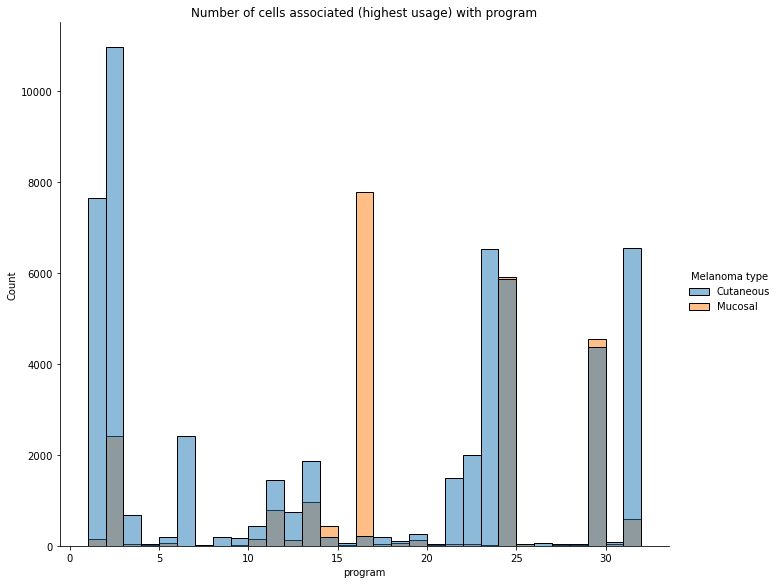

In [32]:
sns.reset_orig() 
ddd = pd.DataFrame(np.concatenate([cutaneous_high_prog, mucosal_high_prog]), columns=['program'])
ddd['Melanoma type'] = ['Cutaneous']*len(cutaneous_high_prog) + ['Mucosal']*len(mucosal_high_prog)
sns.displot(data=ddd, x='program', hue='Melanoma type', common_norm=False,height=8, aspect=1.2).set(title=f'Number of cells associated (highest usage) with program');

Conduct ranksum test:

In [33]:
cutaneous_associated_program_count_df = pd.DataFrame(df_cutaneous.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
cutaneous_samples = cutaneous_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in cutaneous_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  cutaneous_associated_program_count_df[cutaneous_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_cutaneous_patients_usage = {p: [samples_dic[sample][p]  for sample in cutaneous_samples] for p in range(1, selected_K+1)}



mucosal_associated_program_count_df = pd.DataFrame(df_mucosal.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
mucosal_samples = mucosal_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in mucosal_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  mucosal_associated_program_count_df[mucosal_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_mucosal_patients_usage = {p: [samples_dic[sample][p]  for sample in mucosal_samples] for p in range(1, selected_K+1)}

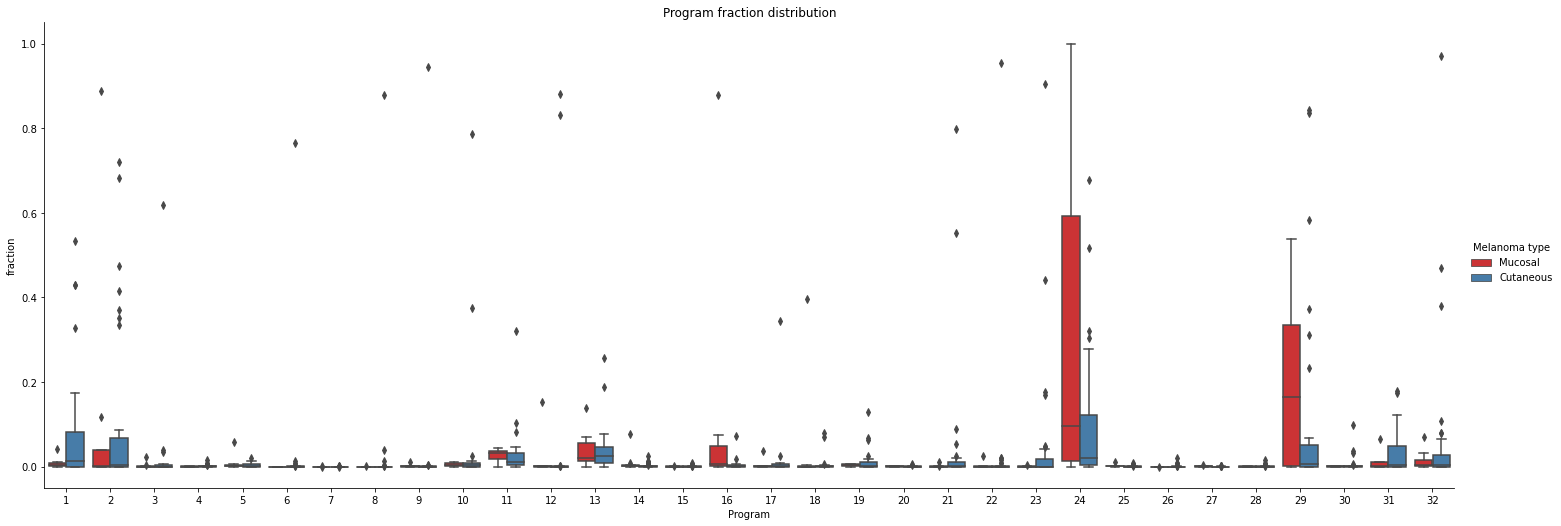

In [35]:
stat_test_prog_frac_df = pd.DataFrame(columns=['Melanoma type', 'fraction', 'Program'])

for prog_idx, fraction_list in programs_mucosal_patients_usage.items():
    for fraction in fraction_list:
        stat_test_prog_frac_df = stat_test_prog_frac_df.append(pd.DataFrame([['Mucosal', fraction, prog_idx]], columns=stat_test_prog_frac_df.columns))
for prog_idx, fraction_list in programs_cutaneous_patients_usage.items():
    for fraction in fraction_list:
        stat_test_prog_frac_df = stat_test_prog_frac_df.append(pd.DataFrame([['Cutaneous', fraction, prog_idx]], columns=stat_test_prog_frac_df.columns))
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Melanoma type', data=stat_test_prog_frac_df, palette="Set1",height=7, aspect=2.9).set(title="Program fraction distribution")

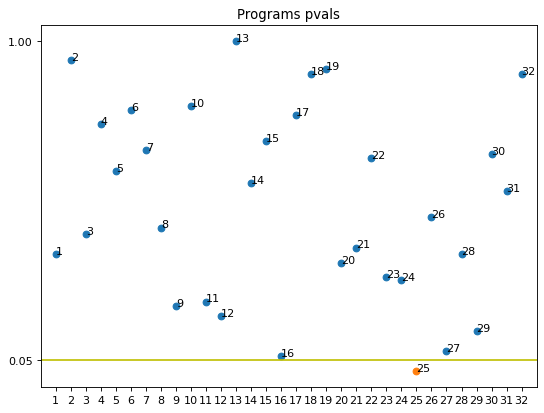

In [37]:
pvals = np.zeros(selected_K)
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(programs_mucosal_patients_usage[i], programs_cutaneous_patients_usage[i])[1]

# Correct pvals
# pvals = multipletests_fdr(pvals)[1].tolist() 
    
pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, selected_K+1)])], columns=['pval', 'program'])


plt.figure(figsize=(8, 6), dpi=80)

pvals = pvals_df[["program", "pval"]].values
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05, 1]);
plt.xlim((0,33));
plt.title('Programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

Specify program and see the fraction of Cutaneous/Mucosal sorted:

['Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Mucosal', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Mucosal', 'Mucosal', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Cutaneous', 'Mucosal', 'Cutaneous', 'Mucosal', 'Mucosal', 'Cutaneous', 'Cutaneous', 'Mucosal', 'Mucosal', 'Cutaneous', 'Cutaneous', 'Cutaneous']


[[0.0, 'Cutaneous'],
 [0.0, 'Cutaneous'],
 [0.0, 'Cutaneous'],
 [0.0, 'Cutaneous'],
 [0.0, 'Cutaneous'],
 [0.0, 'Cutaneous'],
 [0.0, 'Cutaneous'],
 [0.0, 'Cutaneous'],
 [0.0, 'Mucosal'],
 [0.0004363001745200698, 'Cutaneous'],
 [0.0005138746145940391, 'Cutaneous'],
 [0.0009615384615384616, 'Cutaneous'],
 [0.0012991230919129587, 'Cutaneous'],
 [0.0013706140350877192, 'Cutaneous'],
 [0.0021141649048625794, 'Cutaneous'],
 [0.0022316899979711907, 'Cutaneous'],
 [0.002583979328165375, 'Mucosal'],
 [0.0026505111700113595, 'Mucosal'],
 [0.005623242736644799, 'Cutaneous'],
 [0.015592515592515593, 'Cutaneous'],
 [0.018421052631578946, 'Cutaneous'],
 [0.02057416267942584, 'Cutaneous'],
 [0.02855388394227817, 'Cutaneous'],
 [0.03388973191704603, 'Cutaneous'],
 [0.049738219895287955, 'Cutaneous'],
 [0.05128205128205128, 'Cutaneous'],
 [0.05163382389623347, 'Cutaneous'],
 [0.0673758865248227, 'Cutaneous'],
 [0.08601871101871102, 'Mucosal'],
 [0.2335680751173709, 'Cutaneous'],
 [0.2441860465116279, '

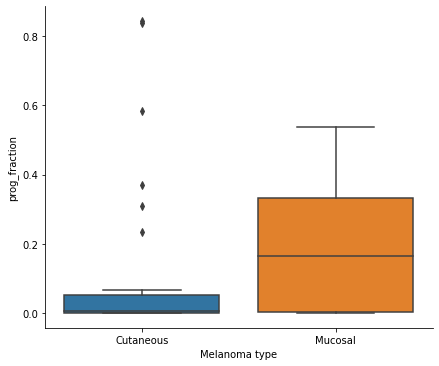

In [82]:
program_idx = 29

patient_fractions = sorted([[x, 'Cutaneous'] for x in programs_cutaneous_patients_usage[program_idx]] + [[x, 'Mucosal'] for x in programs_mucosal_patients_usage[program_idx]])

sns.reset_orig() # reset size of figure
boxplot_df = pd.DataFrame(patient_fractions, columns=['prog_fraction', 'Melanoma type'])
sns.catplot(x='Melanoma type', y="prog_fraction", data=boxplot_df, kind="box",height=5, aspect=1.2);


print([x[1] for x in patient_fractions])
patient_fractions

# Debug

In [86]:
n_samples = 71
pd.set_option('display.max_rows', None)

melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
# melanoma_clinical_data['Therapy after biopsy'].iloc[:46]

def translate(x):
    if not x or str(x)=='nan':
        return 'nothing'
    x = str(x).lower()
    if 'ipi' in x or 'pembro' in x or 'pembo' in x or 'nivo' in x or 'apd' in x or 'pd1' in x:
        return 'ICI'
    
    elif 'enco' in x or 'd+t' in x:
        return 'other therapy'
    
    elif 'radiation' in x:
        return 'other therapy'
    
    elif 'carbo' in x or 'imatinib' in x or 'tmz' in x or 'tvec' in x or 'cdk4/6' in x :
        return 'other immune therapy'
    
    elif 'surgical ' in x or 'surgery ' in x or 'neodajuvant' in x:
        return 'other therapy'
       
    else:
        return x
    
# Counter(melanoma_clinical_data['Therapy(ies) prior to biopsy'].iloc[:46])
x = melanoma_clinical_data['Therapy(ies) prior to biopsy'].iloc[:n_samples].apply(lambda x: translate(x))
y = melanoma_clinical_data['Therapy after biopsy'].iloc[:n_samples].apply(lambda x: translate(x))
z = melanoma_clinical_data.iloc[:n_samples]['Patient id'].tolist()
ICI_df = pd.DataFrame(list(zip(z, x,y, (x == 'ICI') | (y == 'ICI'))), columns=['id', 'prior', 'after', 'ICI'])
# melanoma_clinical_data
ICI_df

,id,prior,after,ICI
0,M97,nothing,ICI,True
1,M98,ICI,other therapy,True
2,M99,ICI,other immune therapy,True
3,M100,ICI,nothing,True
4,M101,nothing,ICI,True
5,M102,ICI,ICI,True
6,M103,nothing,nothing,False
7,M104,ICI,nothing,True
8,M105,ICI,ICI,True
9,M106,ICI,other immune therapy,True


In [78]:
sum(ICI_df['ICI'])

53

In [65]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)


In [69]:

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:71][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].fillna('??')
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
# melanoma_clinical_data


In [70]:
labels_mapping['R '] = 'R'

In [71]:
# adds CRITERIA response into clinical df
# melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')


In [73]:


# Melanoma type
# res_melanoma_clinical_data = res_melanoma_clinical_data[(res_melanoma_clinical_data['Melanoma type']=='Cutaneous') | (res_melanoma_clinical_data['Melanoma type']=='Mucosal ')]
melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal ', 'Uveal': 'other', 'UN primary': 'other', 'Acral': 'other', 'Unknown': 'other', '??':'other'}
res_melanoma_clinical_data['Melanoma type'] = res_melanoma_clinical_data['Melanoma type'].apply(lambda rr: melanoma_type_translate[rr])
res_melanoma_clinical_data

,Clinical response,Melanoma type
Patient id,,
M97,R,Cutaneous
M98,R (had a response in 2016-2019),Cutaneous
M99,NR (PD),Mucosal
M100,NR (SD),Cutaneous
M101,NED- 10/5/20,other
M102,NR (PD),other
M103,NED,other
M104,NR- PD bone (R-viscerally),Cutaneous
M105,NR (PD),other


In [85]:
res_melanoma_clinical_data['Melanoma type'].value_counts()

Cutaneous    49
other        14
Mucosal       8
Name: Melanoma type, dtype: int64

In [11]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

In [35]:
def translate(n):
    if n in ['Cutaneous', 'Mucosal ']:
        return n
    else: return 'other'
melanoma_clinical_data3 = melanoma_clinical_data#[melanoma_clinical_data['Melanoma type'].isin(['Cutaneous', 'Mucosal '])]
melanoma_clinical_data3 = melanoma_clinical_data
melanoma_clinical_data3['Melanoma type'] = melanoma_clinical_data3['Melanoma type'].map(lambda x: translate(x))

melanoma_clinical_data.groupby(['Melanoma type', 'response']).count()
melanoma_clinical_data3.groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['Clinical response']).rename(columns={'Patient id': 'number of samples'})
# set(melanoma_clinical_data['Melanoma type'].tolist())

,Melanoma type,response,number of samples
0,Cutaneous,NR,16
1,Cutaneous,R,9
2,Cutaneous,not in use for now,6
3,Mucosal,NR,5
4,Mucosal,R,2
5,Mucosal,not in use for now,1
6,other,NR,4
7,other,R,3


In [3]:
# melanoma_clinical_data2 = melanoma_clinical_data
# melanoma_clinical_data2

In [36]:

indices = sorted((np.random.rand(1000)*cohort.number_of_cells).astype(int))
# indices

In [37]:
path = r'/storage/md_keren/shitay/garbage/1000_rand_cells.pkl'
pickle.dump(cohort[indices], open(path, 'wb'))